In [2]:
from scipy.stats import binned_statistic
import numpy as np
import pandas as pd
from ipyvizzu import Chart, Data, Config, Style
from ipyvizzustory import Story, Slide, Step
from pathlib import Path
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from IPython.display import display as display_html, HTML 

In [3]:
# Load data
# np.savez_compressed(Path('/mnt/c/Data/STEREO/L7tum/prep_fits/balltrack/mblt.npz'), ballpos=mbt.ballpos)
mbt = np.load(Path('/mnt/c/Data/STEREO/L7tum/prep_fits/balltrack/mblt.npz'))

DSUN_OBS= 1.433675e6 # km
DT = 5*60 # 5 minutes time interval between each frame
CDELT2  = 0.0141875720451562 # solar radius / px
VUNIT = CDELT2 * (DSUN_OBS/2)/DT 

In [4]:
ballpos = mbt['ballpos'].copy()
# Remove the balls that are only here for a few frames - use ballage!
keep_tracks_mask = mbt['balls_age'][:, -1] >= 5
ballpos = ballpos[:, keep_tracks_mask, :]

In [5]:
fwhm = 20
nx = 3600
ny = 659

# TODO: Instead of doing what I did below, should take 1st and final position of each given ball, 
# and differentiate that. The ball age should be used, the tracks doesn't start at time index = 0 either
# and do not end at time index = -1, right? 
bposx = ballpos[0, :, :].copy()
bposy = ballpos[1, :, :].copy()
nan_mask = bposx == -1
bposx[nan_mask] = np.nan
bposy[nan_mask] = np.nan

vx_lagrange = (bposx[:, 1:] - bposx[:, 0:-1])*VUNIT
vy_lagrange = (bposy[:, 1:] - bposy[:, 0:-1])*VUNIT

px_lagrange = np.round((bposx[:, 0:-1] + bposx[:, 1:])/2)
py_lagrange = np.round((bposy[:, 0:-1] + bposy[:, 1:])/2)
# Exclude NaN flagged positions using a mask.
valid_mask = np.isfinite(vx_lagrange)
# Taking the mask of the 2D arrays convert them to 1D arrays
px_lagrange = px_lagrange[valid_mask]
py_lagrange = py_lagrange[valid_mask]
vx_lagrange = vx_lagrange[valid_mask]
vy_lagrange = vy_lagrange[valid_mask]
# Convert 2D coordinates of position into 1D indices. These are the 1D position of each v*_lagrange data point
p1d = (px_lagrange + py_lagrange*nx).astype(np.uint32)
# Weight plane. Add 1 for each position
wplane = np.zeros([ny*nx])
np.add.at(wplane, p1d, 1)
# Build the Euler velocity map
# vxplane = np.zeros([ny, nx])
# vyplane = np.zeros([ny, nx])
vx_euler = np.zeros([nx*ny])
vy_euler = np.zeros([nx*ny])

for j in range(p1d.size):
    vx_euler[p1d[j]] += vx_lagrange[j]
    vy_euler[p1d[j]] += vy_lagrange[j]
    
vx_euler = vx_euler.reshape([ny, nx])
vy_euler = vy_euler.reshape([ny, nx])
wplane   = wplane.reshape([ny, nx])

# Spatial average (convolve with gaussian)
sigma = fwhm/2.35
vx_euler = gaussian_filter(vx_euler, sigma=sigma, order=0)
vy_euler = gaussian_filter(vy_euler, sigma=sigma, order=0)
wplane   = gaussian_filter(wplane, sigma=sigma, order=0)

vx_euler /= wplane
vy_euler /= wplane

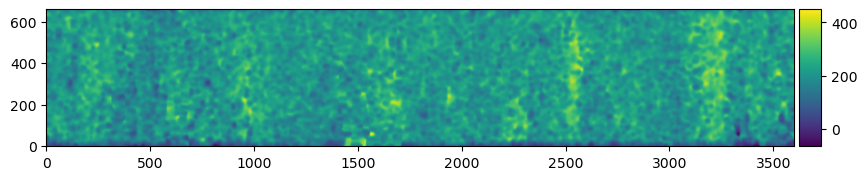

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,1, figsize=(10,5))
im = ax.imshow(vy_euler, origin='lower', cmap='viridis')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
plt.colorbar(im, cax=cax)

In [7]:
# npzf = np.load('vizzu_velocity_data.npz')
# px_tavg, vy_tavg = npzf['px_tavg'], npzf['vy_tavg']

In [8]:
# Make velocities averaged three different heights, and another average over the whole y-axis
hwidth = ny//3
heights = np.round(np.arange(0, ny, hwidth))
vys = [vy_euler[h:h+hwidth, :].mean(axis=0) for h in heights[:-1]]
# Make the whole-axis average, which Vizzu will use transition to the three heights
vy_avg = vy_euler.mean(axis=0)
# Flip so that we have the bins as 360 - deg_bins, without having to resort the array
vy_avg = vy_avg[::-1]
xcoords = np.arange(0, nx)

In [9]:
angular_bins = np.arange(0, nx+1, 100)

# Make the whole-axis statistic
bin_means_whole_axis, bin_edges, binnumber = binned_statistic(xcoords, vy_avg, statistic='mean', bins=angular_bins)
deg_bins = (bin_edges[:-1]+bin_edges[1:])/2/10

deg_bins_str = [str(deg)+ u'\N{DEGREE SIGN}' for deg in deg_bins.astype(int)] 

,px,vy,vy_avg,sigma,Height
0,5°,164.071891,66.494064,18.433827,5 Rs
1,15°,197.873523,70.500433,12.786287,5 Rs
2,25°,154.866911,65.125456,25.630365,5 Rs
3,35°,235.698025,86.978272,32.720575,5 Rs
4,45°,219.039200,81.793052,18.063191,5 Rs


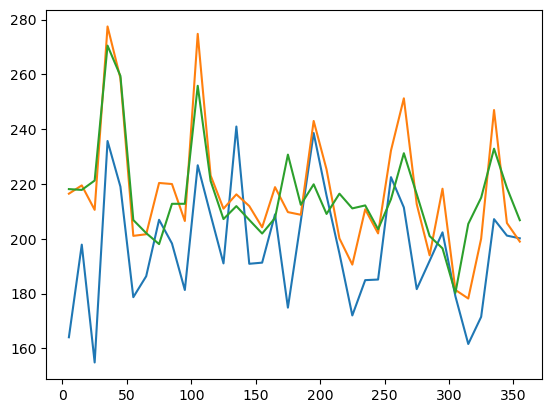

In [10]:
df_list = []

# Make the 3-height statistic
plt.figure()
for i in range(3):
    # Flip so that we have the bins as 360 - deg_bins, without having to resort the array
    vy = vys[i][::-1]
    bin_means, bin_edges, binnumber = binned_statistic(xcoords, vy, statistic='mean', bins=angular_bins)
    bin_std, _, _ = binned_statistic(xcoords, vy, statistic='std', bins=angular_bins)
    bin_count, _, _ = binned_statistic(xcoords, vy, statistic='count', bins=angular_bins)
    vmean_err = bin_std/np.sqrt(bin_count)
    vmean = bin_means.mean()
    deg_bins = (bin_edges[:-1]+bin_edges[1:])/2/10
    
    df = pd.DataFrame({
        'px': deg_bins_str,
        'vy': bin_means,
        'vy_avg': bin_means_whole_axis/3, # divided by the number of heights for Vizzu to make sense
        'sigma': bin_std,
        'Height': f'{(i+1)*5} Rs'
    })
    
    df_list.append(df)
    
    plt.plot(deg_bins, bin_means)

df = pd.concat(df_list)
df.head()

In [77]:
data = Data()
data.add_df(df)

# Set the style of the charts in the story

style1 = Style(
    {
        'plot': {
            'yAxis': {
                # 'color': '#080600',
                'guides':{
                    'color':'#080600'
                },
                'interlacing': {"color": "#ffffff00"},
                'label': {
                    'fontSize': '1em',
                    'paddingRight': '1.2em',
                },
            },
            'xAxis': {
                #'color':'#080600',
                'guides':{
                    'color':'#080600'
                },
                'interlacing': {"color": "#ffffff00"},
                'label': {
                    'fontSize': '1em',
                    'paddingRight': '2em',
                    'angle':'2.5',
                },
                'ticks':{
                    'color': '#080600',
                    'length': '0.5em',
                    'position': 'outside'
                },
                'title': {'fontSize': '1em', 'paddingTop': '2.5em'},
            },
        },
        'legend': {
            'label': {
                'fontSize': '1.5em',
            },
            'width': '20em'
        }
    }
)

style2 = Style(
    {
        'plot': {
            'yAxis': {
                # 'color': '#080600',
                'guides':{
                    'color':'#080600'
                },
                'interlacing': {"color": "#ffffff00"},
                'label': {
                    'fontSize': '1em',
                    'paddingRight': '1.2em',
                    # 'color': "#ffffff00",
                },
                'title': {'color': '#00000000'},
            },
            'marker': {
                'colorPalette' : '#00000000' #invisible
            },
            'xAxis': {
                #'color':'#080600',
                'guides':{
                    'color':'#080600'
                },
                'interlacing': {"color": "#ffffff00"},
                'label': {
                    'fontSize': '1em',
                    'paddingRight': '2em',
                    'angle':'2.5',
                },
                'ticks':{
                    'color': '#080600',
                    'length': '0.5em',
                    'position': 'outside'
                },
                'title': {'fontSize': '1em', 'paddingTop': '2.5em'},
            },
        },
        'legend': {
            'label': {
                'fontSize': '1.5em',
            },
            'width': '20em'
        }
    }
)

# Create Story object, set size

story = Story(data=data)
story.set_size('1000px', '500px')
 
# Slide 1
story.add_slide(Slide(
    Step(
        Config(
            {
                "x": "px",
                "y": "vy_avg", 
                "geometry":"line",
                "title" : "Averaged radial velocity (km/s) [0-360 deg.]"
            }
        ),
        style1
    )
))

# Slide 2
story.add_slide(Slide(
    Step(
            Config.polarLine(
        {
            "angle": "px",
            "radius": "vy_avg",
            "title": "Averaged radial velocity (km/s)",
        }
    ),
        Style({'plot' : {'xAxis' : {'label' : {'angle' : '0'}}}})
)
))

# Slide 3
story.add_slide(Slide(
    Step(
            Config.polarLine(
        {
            "angle": "px",
            "radius": "vy",
            "dividedBy": "Height",
            "title": "Height-separated radial velocity (km/s)",
        }
    ),
        regroupStrategy="drilldown"
)
))

# Slide 4
story.add_slide(Slide(
    Step(
            Config(
        {
            "x": "px",
            "y": "vy",
            "geometry":"line",
            "coordSystem":"polar",
            "color": "Height",
            "size":"sigma",
            "title": "Height-separated radial-assumed velocity (km/s) with error bands",
        }
    ),
        regroupStrategy="drilldown"
)
)
)


# handler = """
# const currentSlide = document.getElementById("current-slide");
# if (currentSlide !== 0 && window.storyImages[currentSlide.innerHTML]) {
#     event.renderingContext.drawImage(window.storyImages[currentSlide.innerHTML], 0, 0,
#         event.data.rect.size.x, event.data.rect.size.y);
#     event.preventDefault();
# }
# """

handler = """
const currentSlide = document.getElementById("current-slide");
if (currentSlide !== 0 && window.storyImages[currentSlide.innerHTML]) {
    event.renderingContext.drawImage(window.storyImages[currentSlide.innerHTML], 10, 20,
        935, 350);
    event.preventDefault();
}
"""

story.add_event("background-draw", handler)

update_event_html = """
<div><script type="module">
window.storyImages = {};
window.storyImages[1] = new Image();
window.storyImages[1].src = 'https://github.com/raphael-attie/stereo_solar_flow_tracking/raw/main/notebooks/L3_cor2.png';
window.storyImages[2] = new Image();
window.storyImages[2].src = "https://vizzuhq.com/images/logo/logo.svg";

window.storyImages[1].onload = () => {
window.storyImages[2].onload = () => {
// ...
// window.storyImages[N].onload = () => {
const vp = document.querySelector("vizzu-player");
vp.initializing.then(chart => {
    vp.addEventListener('update', (e) => {
        var slide_num = Number(`${e.detail.currentSlide}`) + 1
        
        switch (slide_num) {
            case 1:
                document.getElementById("current-slide").innerHTML = 1;
                chart.render.updateFrame(true);
                break;
            case 2:
                document.getElementById("current-slide").innerHTML = 2;
                chart.render.updateFrame(true);
                break;
            default:
                break;
        }
    });
});
};
};
</script></div>
"""

display_html(HTML("""<div id="current-slide" style="display: none;">0</div>"""))
# Play the created story
story.play()
display_html(HTML(update_event_html))

In [12]:
story.set_size('100%', '100%')
story.export_to_html(filename='punch_radial_flows.html')